In [1]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')



In [3]:
urls = search_images('dangerous mushrooms', max_images=1)
urls[0]

'http://cdn0.wideopenpets.com/wp-content/uploads/2018/03/AdobeStock_171168568.jpeg'

In [4]:
Test = 'mush.jpg'
download_url(urls[0], Test, show_progress=False)

Path('mush.jpg')

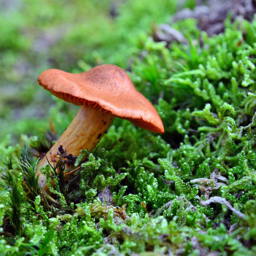

In [5]:
im = Image.open(Test)
im.to_thumb(256,256)

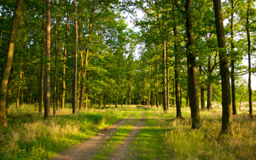

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [7]:
searches = 'forest','dangerous mushrooms'
path = Path('dangerousmush_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

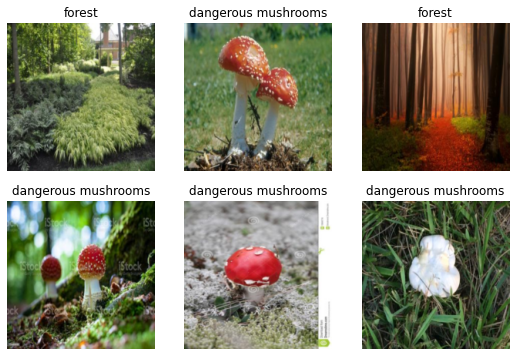

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


C:\Users\Benoit\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Benoit\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.325186,0.022717,0.004376,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.024766,0.013403,0.008753,01:48
1,0.020388,0.011925,0.004376,01:51
2,0.011119,0.006526,0.004376,01:51


In [11]:
is_mush,_,probs = learn.predict(PILImage.create('mush.jpg'))
print(f"This is a: {is_mush}.")
print(f"Probability it's a dangerous mushroom: {probs[0]:.4f}")

This is a: dangerous mushrooms.
Probability it's a dangerous mushroom: 0.9999


In [12]:
learn.export('Mushreco.pkl')

In [13]:
learn = load_learner('Mushreco.pkl') 

In [15]:
from fastai.vision.all import * 
import gradio as gr

learn = load_learner('Mushreco.pkl')

guesting = ('Mushroom','forest')
def prediction(img):
    pred,idx,probs = learn.predict(PILImage.create(img))
    return dict(zip(guesting, map(float,probs)))


image = gr.inputs.Image(shape=(192, 192))
label = gr.outputs.Label()
examples = ['mush.jpg', 'forest.jpg']
intf = gr.Interface(fn=prediction, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

C:\Users\Benoit\AppData\Roaming\Python\Python39\site-packages\gradio\inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\Benoit\AppData\Roaming\Python\Python39\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Benoit\AppData\Roaming\Python\Python39\site-packages\gradio\outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\Benoit\AppData\Roaming\Python\Python39\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
